In [1]:
# Install core dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install ONNX and supporting libraries
!pip install onnxruntime==1.13.1
!pip install onnxruntime-gpu==1.13.1

# Install utility libraries
!pip install matplotlib==3.6.2
!pip install opencv-python==4.7.0.68
!pip install scipy==1.11.4
!pip install scikit-image==0.19.3
!pip install huggingface_hub==0.20.1

# Install DWPose (ONNX-based version)
!pip install dwpose


Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.13.1 (from versions: 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.17.0, 1.17.1, 1.17.3, 1.18.0, 1.18.1, 1.19.0, 1.19.2, 1.20.0, 1.20.1, 1.21.0, 1.21.1, 1.22.0)
ERROR: No matching distribution found for onnxruntime==1.13.1
ERROR: Could not find a version that satisfies the requirement onnxruntime-gpu==1.13.1 (from versions: 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.17.0, 1.17.1, 1.18.0, 1.18.1, 1.19.0, 1.19.2, 1.20.0, 1.20.1, 1.20.2, 1.21.0, 1.21.1, 1.22.0)
ERROR: No matching distribution found for onnxruntime-gpu==1.13.1
  Using cached scikit-image-0.19.3.tar.gz (22.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-image: filename=scikit_image-0.19.3-cp311-cp311-linux_x86_64.whl size=33913347 sha256=bb404ca34c1a65371620968

In [2]:
!pip install onnxruntime==1.17.1
!pip install onnxruntime-gpu==1.17.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 6.8 MB/s eta 0:00:00


Saving clips_10s_video1_clip_000_frame_0000.jpg to clips_10s_video1_clip_000_frame_0000 (3).jpg
Uploaded: clips_10s_video1_clip_000_frame_0000 (3).jpg

DWPose: Using yolox_l.onnx for bbox detection and dw-ll_ucoco_384.onnx for pose estimation
DWPose: Bbox 1534.85ms
DWPose: Pose 266.50ms on 1 people

Detected 1 person(s) in full image
DWPose: Bbox 1480.68ms
DWPose: Pose 227.77ms on 1 people

No valid bbox found, falling back to first detected person.
✅ Saved normalized pose to normalized_pose.json


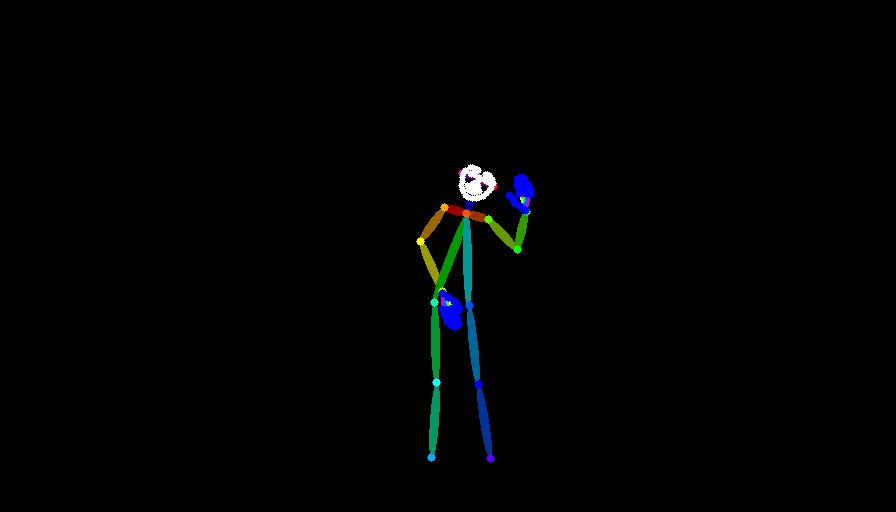

In [3]:
from google.colab import files
uploaded = files.upload()

# Get the uploaded file path
image_path = next(iter(uploaded))
print("Uploaded:", image_path)

from dwpose import DwposeDetector
from PIL import Image
import numpy as np
import json
import os

# === Setup ===
video_path = image_path
output_json = "normalized_pose.json"

# === Load DWPose model ===
model = DwposeDetector.from_pretrained_default()

# === Load and crop image ===
img = Image.open(video_path).convert("RGB")
img_width, img_height = img.size
left_img = img.crop((0, 0, img_width // 2, img_height))

# === Step 1: Count people in full image ===
_, keypoints_json_full, _ = model(
    img,
    include_hand=True,
    include_face=True,
    include_body=True,
    image_and_json=True,
    detect_resolution=512
)

num_people = len(keypoints_json_full.get('people', []))
print(f"Detected {num_people} person(s) in full image")

# === Step 2: Choose cropped input if needed ===
selected_img = img if num_people <= 1 else left_img

# === Step 3: Final inference ===
imgOut, keypoints_json_all, source_img = model(
    selected_img,
    include_hand=True,
    include_face=True,
    include_body=True,
    image_and_json=True,
    detect_resolution=512
)

# === Step 4: Try to get person closest to center, fallback to first person ===
def get_bbox_center(bbox):
    x, y, w, h = bbox
    return np.array([x + w / 2, y + h / 2])

people = keypoints_json_all.get('people', [])
if not people:
    raise ValueError("No people detected in the selected image.")

image_center = np.array([img_width / 2, img_height / 2])
min_dist = float('inf')
best_person = None

for person in people:
    bbox = person.get('bbox')
    if bbox is None:
        continue
    center = get_bbox_center(bbox)
    dist = np.linalg.norm(center - image_center)
    if dist < min_dist:
        min_dist = dist
        best_person = person

# Fallback if no person with valid bbox
if best_person is None:
    print("No valid bbox found, falling back to first detected person.")
    best_person = people[0]

# === Normalize pose ===
pose_flat = best_person["pose_keypoints_2d"]
pose = np.array(pose_flat).reshape(-1, 3)   # (J, 3)
pose_xy = pose[:, :2]

# Center by hips
hip_center = (pose_xy[11] + pose_xy[12]) / 2

# Scale by shoulder span
shoulder_span = np.linalg.norm(pose_xy[5] - pose_xy[6])
if shoulder_span == 0:
    raise ValueError("Shoulder span is zero — possibly missing keypoints.")

pose_normalized = (pose_xy - hip_center) / shoulder_span

# Compute relative vectors
edges = [
    (5, 7), (7, 9),     # left arm
    (6, 8), (8, 10),    # right arm
    (11, 13), (13, 15), # left leg
    (12, 14), (14, 16), # right leg
    (5, 6), (11, 12),   # shoulders + hips
    (5, 11), (6, 12)    # torso
]
rel_pose = [(pose_normalized[j] - pose_normalized[i]).tolist() for i, j in edges]

# === Save JSON ===
data = {
    "image": os.path.basename(video_path),
    "pose_normalized": pose_normalized.tolist(),
    "relative_pose_vectors": rel_pose,
    "edges": edges
}

with open(output_json, "w") as f:
    json.dump(data, f, indent=2)

# === Save visual output ===
imgOut.save("openpose_output.jpg")
source_img.save("source_resized.jpg")

print(f"✅ Saved normalized pose to {output_json}")

# === Show pose output ===
from IPython.display import Image as IPyImage
IPyImage("openpose_output.jpg")



In [ ]:
from dwpose import DwposeDetector
from PIL import Image
import numpy as np
import json
import os
from tqdm import tqdm
from google.cloud import storage

# ==== CONFIG ====
bucket_name = "ucftoy-dataset"
gcs_input_root = "clips_10s_video1"
gcs_output_root = "pose_jsons"
local_root = "/tmp/pose_processing"

# ==== INIT ====
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
model = DwposeDetector.from_pretrained_default()

# ==== UTILS ====
def get_bbox_center(bbox):
    x, y, w, h = bbox
    return np.array([x + w / 2, y + h / 2])

def list_clip_folders():
    blobs = storage_client.list_blobs(bucket_name, prefix=gcs_input_root + "/")
    return sorted(set(b.name.split("/")[1] for b in blobs if "frame_" in b.name))

# ==== PROCESSING LOOP ====
for clip_id in list_clip_folders():
    gcs_clip_path = f"{gcs_input_root}/{clip_id}"
    print(f"\nProcessing {gcs_clip_path}...")

    blobs = storage_client.list_blobs(bucket_name, prefix=gcs_clip_path)
    frame_blobs = sorted([b for b in blobs if b.name.endswith(".jpg")], key=lambda b: b.name)

    for blob in tqdm(frame_blobs, desc=f"🎯 {clip_id}"):
        filename = os.path.basename(blob.name)
        local_dir = os.path.join(local_root, clip_id)
        os.makedirs(local_dir, exist_ok=True)

        local_path = os.path.join(local_dir, filename)
        blob.download_to_filename(local_path)

        try:
            img = Image.open(local_path).convert("RGB")
            img_width, img_height = img.size
            left_img = img.crop((0, 0, img_width // 2, img_height))

            # Step 1: count people in full image
            _, keypoints_json_full, _ = model(
                img,
                include_hand=True,
                include_face=True,
                include_body=True,
                image_and_json=True,
                detect_resolution=512
            )
            num_people = len(keypoints_json_full.get("people", []))
            selected_img = img if num_people <= 1 else left_img

            # Step 2: final pose estimation
            _, keypoints_json, _ = model(
                selected_img,
                include_hand=True,
                include_face=True,
                include_body=True,
                image_and_json=True,
                detect_resolution=512
            )

            people = keypoints_json.get("people", [])
            if not people:
                continue

            # Step 3: pick person closest to center
            image_center = np.array([selected_img.width / 2, selected_img.height / 2])
            best_person = None
            min_dist = float('inf')
            for person in people:
                bbox = person.get("bbox")
                if bbox is None:
                    continue
                center = get_bbox_center(bbox)
                dist = np.linalg.norm(center - image_center)
                if dist < min_dist:
                    min_dist = dist
                    best_person = person
            if best_person is None:
                best_person = people[0]  # fallback

            # Step 4: normalize pose
            pose_flat = best_person["pose_keypoints_2d"]
            pose = np.array(pose_flat).reshape(-1, 3)
            pose_xy = pose[:, :2]

            hip_center = (pose_xy[11] + pose_xy[12]) / 2
            shoulder_span = np.linalg.norm(pose_xy[5] - pose_xy[6])
            if shoulder_span == 0:
                continue

            pose_normalized = (pose_xy - hip_center) / shoulder_span

            edges = [
                (5, 7), (7, 9), (6, 8), (8, 10),
                (11, 13), (13, 15), (12, 14), (14, 16),
                (5, 6), (11, 12), (5, 11), (6, 12)
            ]
            rel_pose = [(pose_normalized[j] - pose_normalized[i]).tolist() for i, j in edges]

            # Step 5: Save JSON
            json_data = {
                "image": filename,
                "pose_normalized": pose_normalized.tolist(),
                "relative_pose_vectors": rel_pose,
                "edges": edges
            }

            json_name = filename.replace(".jpg", ".json")
            local_json_path = os.path.join(local_dir, json_name)

            with open(local_json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            # Upload to GCS
            gcs_json_path = f"{gcs_output_root}/{clip_id}/{json_name}"
            blob_out = bucket.blob(gcs_json_path)
            blob_out.upload_from_filename(local_json_path)

        except Exception as e:
            print(f"Error in {filename}: {e}")



DWPose: Using yolox_l.onnx for bbox detection and dw-ll_ucoco_384.onnx for pose estimation

Processing clips_10s_video1/clip_001...


🎯 clip_001:   0%|          | 0/300 [00:00<?, ?it/s]

DWPose: Bbox 1429.69ms
DWPose: Pose 225.11ms on 1 people

DWPose: Bbox 1424.54ms


🎯 clip_001:   0%|          | 1/300 [00:03<18:50,  3.78s/it]

DWPose: Pose 228.20ms on 1 people

DWPose: Bbox 2128.06ms
DWPose: Pose 227.94ms on 1 people

DWPose: Bbox 1450.55ms


🎯 clip_001:   1%|          | 2/300 [00:08<21:27,  4.32s/it]

DWPose: Pose 237.06ms on 1 people

DWPose: Bbox 1515.60ms
DWPose: Pose 230.74ms on 1 people

DWPose: Bbox 1428.46ms


🎯 clip_001:   1%|          | 3/300 [00:12<20:53,  4.22s/it]

DWPose: Pose 230.71ms on 1 people

DWPose: Bbox 1449.13ms
DWPose: Pose 234.72ms on 1 people

DWPose: Bbox 1525.48ms


🎯 clip_001:   1%|▏         | 4/300 [00:16<20:49,  4.22s/it]

DWPose: Pose 336.08ms on 1 people

DWPose: Bbox 1879.81ms
DWPose: Pose 236.78ms on 1 people

DWPose: Bbox 1508.57ms


🎯 clip_001:   2%|▏         | 5/300 [00:21<21:15,  4.32s/it]

DWPose: Pose 236.70ms on 1 people

DWPose: Bbox 1430.12ms
DWPose: Pose 234.64ms on 1 people

DWPose: Bbox 1473.71ms


🎯 clip_001:   2%|▏         | 6/300 [00:25<20:43,  4.23s/it]

DWPose: Pose 247.51ms on 1 people

DWPose: Bbox 1492.86ms
DWPose: Pose 247.60ms on 1 people

DWPose: Bbox 1735.53ms


🎯 clip_001:   2%|▏         | 7/300 [00:29<21:03,  4.31s/it]

DWPose: Pose 325.61ms on 1 people

DWPose: Bbox 1487.41ms
DWPose: Pose 236.72ms on 1 people

DWPose: Bbox 1498.20ms


🎯 clip_001:   3%|▎         | 8/300 [00:33<20:43,  4.26s/it]

DWPose: Pose 241.93ms on 1 people

DWPose: Bbox 1441.57ms
DWPose: Pose 219.51ms on 1 people

DWPose: Bbox 1410.18ms


🎯 clip_001:   3%|▎         | 9/300 [00:37<20:11,  4.16s/it]

DWPose: Pose 212.14ms on 1 people

DWPose: Bbox 1488.83ms
DWPose: Pose 220.96ms on 1 people

DWPose: Bbox 1861.32ms


🎯 clip_001:   3%|▎         | 10/300 [00:42<20:46,  4.30s/it]

DWPose: Pose 317.48ms on 1 people

DWPose: Bbox 1479.51ms
DWPose: Pose 246.30ms on 1 people

DWPose: Bbox 1496.12ms


🎯 clip_001:   4%|▎         | 11/300 [00:46<20:24,  4.24s/it]

DWPose: Pose 221.15ms on 1 people

DWPose: Bbox 1429.18ms
DWPose: Pose 234.31ms on 1 people

DWPose: Bbox 1451.52ms


🎯 clip_001:   4%|▍         | 12/300 [00:50<19:59,  4.16s/it]

DWPose: Pose 228.64ms on 1 people

DWPose: Bbox 1409.40ms
DWPose: Pose 223.93ms on 1 people

DWPose: Bbox 2060.00ms


🎯 clip_001:   4%|▍         | 13/300 [00:55<20:42,  4.33s/it]

DWPose: Pose 333.06ms on 1 people

DWPose: Bbox 1437.03ms
DWPose: Pose 247.82ms on 1 people

DWPose: Bbox 1407.62ms


🎯 clip_001:   5%|▍         | 14/300 [00:59<20:15,  4.25s/it]

DWPose: Pose 226.36ms on 1 people

DWPose: Bbox 1434.71ms
DWPose: Pose 249.63ms on 1 people

DWPose: Bbox 1444.71ms


🎯 clip_001:   5%|▌         | 15/300 [01:03<19:52,  4.18s/it]

DWPose: Pose 225.13ms on 1 people

DWPose: Bbox 1525.01ms
DWPose: Pose 344.46ms on 1 people

DWPose: Bbox 2138.13ms


🎯 clip_001:   5%|▌         | 16/300 [01:08<20:59,  4.43s/it]

DWPose: Pose 308.20ms on 1 people

DWPose: Bbox 1467.93ms
DWPose: Pose 263.60ms on 1 people

DWPose: Bbox 1433.18ms


🎯 clip_001:   6%|▌         | 17/300 [01:12<20:21,  4.32s/it]

DWPose: Pose 231.38ms on 1 people

DWPose: Bbox 1501.73ms
DWPose: Pose 240.79ms on 1 people

DWPose: Bbox 1432.69ms


🎯 clip_001:   6%|▌         | 18/300 [01:16<19:57,  4.25s/it]

DWPose: Pose 240.56ms on 1 people

DWPose: Bbox 1600.80ms
DWPose: Pose 332.49ms on 1 people

DWPose: Bbox 2092.53ms


🎯 clip_001:   6%|▋         | 19/300 [01:21<20:53,  4.46s/it]

DWPose: Pose 229.95ms on 1 people

DWPose: Bbox 1465.67ms
DWPose: Pose 250.89ms on 1 people

DWPose: Bbox 1483.28ms


🎯 clip_001:   7%|▋         | 20/300 [01:25<20:19,  4.36s/it]

DWPose: Pose 239.68ms on 1 people

DWPose: Bbox 1717.17ms
DWPose: Pose 224.69ms on 1 people

DWPose: Bbox 1491.88ms


🎯 clip_001:   7%|▋         | 21/300 [01:30<20:15,  4.36s/it]

DWPose: Pose 270.12ms on 1 people

DWPose: Bbox 1920.11ms
DWPose: Pose 342.09ms on 1 people

DWPose: Bbox 1795.47ms


🎯 clip_001:   7%|▋         | 22/300 [01:34<21:02,  4.54s/it]

DWPose: Pose 229.34ms on 1 people

DWPose: Bbox 1982.75ms
DWPose: Pose 235.85ms on 1 people

DWPose: Bbox 1427.24ms


🎯 clip_001:   8%|▊         | 23/300 [01:39<21:00,  4.55s/it]

DWPose: Pose 244.75ms on 1 people

DWPose: Bbox 1414.30ms
DWPose: Pose 221.00ms on 1 people

DWPose: Bbox 1415.01ms


🎯 clip_001:   8%|▊         | 24/300 [01:43<20:02,  4.36s/it]

DWPose: Pose 231.62ms on 1 people

DWPose: Bbox 2206.23ms
DWPose: Pose 253.08ms on 1 people

DWPose: Bbox 1459.18ms


🎯 clip_001:   8%|▊         | 25/300 [01:48<20:38,  4.50s/it]

DWPose: Pose 230.79ms on 1 people

DWPose: Bbox 1474.30ms
DWPose: Pose 236.49ms on 1 people

DWPose: Bbox 1458.70ms


🎯 clip_001:   9%|▊         | 26/300 [01:52<20:06,  4.40s/it]

DWPose: Pose 229.54ms on 1 people

DWPose: Bbox 1418.24ms
DWPose: Pose 219.48ms on 1 people

DWPose: Bbox 1419.21ms


🎯 clip_001:   9%|▉         | 27/300 [01:56<19:23,  4.26s/it]

DWPose: Pose 226.04ms on 1 people

DWPose: Bbox 1963.38ms
DWPose: Pose 250.64ms on 1 people

DWPose: Bbox 1438.18ms


🎯 clip_001:   9%|▉         | 28/300 [02:00<19:42,  4.35s/it]

DWPose: Pose 230.98ms on 1 people

DWPose: Bbox 1401.55ms
DWPose: Pose 223.19ms on 1 people

DWPose: Bbox 1429.29ms


🎯 clip_001:  10%|▉         | 29/300 [02:04<19:04,  4.22s/it]

DWPose: Pose 224.06ms on 1 people

DWPose: Bbox 1388.22ms
DWPose: Pose 226.85ms on 1 people

DWPose: Bbox 1542.48ms
DWPose: Pose 330.96ms on 1 people



🎯 clip_001:  10%|█         | 30/300 [02:09<19:16,  4.28s/it]

DWPose: Bbox 1760.74ms
DWPose: Pose 244.89ms on 1 people

DWPose: Bbox 1417.86ms


🎯 clip_001:  10%|█         | 31/300 [02:13<18:56,  4.23s/it]

DWPose: Pose 235.33ms on 1 people

DWPose: Bbox 1437.39ms
DWPose: Pose 232.38ms on 1 people

DWPose: Bbox 1431.71ms


🎯 clip_001:  11%|█         | 32/300 [02:17<18:38,  4.17s/it]

DWPose: Pose 235.92ms on 1 people

DWPose: Bbox 1417.95ms
DWPose: Pose 232.02ms on 1 people

DWPose: Bbox 1697.02ms


🎯 clip_001:  11%|█         | 33/300 [02:21<18:48,  4.23s/it]

DWPose: Pose 336.22ms on 1 people

DWPose: Bbox 1569.41ms
DWPose: Pose 238.16ms on 1 people

DWPose: Bbox 1436.96ms


🎯 clip_001:  11%|█▏        | 34/300 [02:25<18:37,  4.20s/it]

DWPose: Pose 219.14ms on 1 people

DWPose: Bbox 1430.93ms
DWPose: Pose 217.92ms on 1 people

DWPose: Bbox 1402.06ms


🎯 clip_001:  12%|█▏        | 35/300 [02:29<18:12,  4.12s/it]

DWPose: Pose 215.56ms on 1 people

DWPose: Bbox 1419.14ms
DWPose: Pose 229.17ms on 1 people

DWPose: Bbox 1866.60ms


🎯 clip_001:  12%|█▏        | 36/300 [02:34<18:39,  4.24s/it]

DWPose: Pose 326.32ms on 1 people

DWPose: Bbox 1484.86ms
DWPose: Pose 241.20ms on 1 people

DWPose: Bbox 1420.88ms


🎯 clip_001:  12%|█▏        | 37/300 [02:38<18:23,  4.20s/it]

DWPose: Pose 226.81ms on 1 people

DWPose: Bbox 1457.17ms
DWPose: Pose 243.86ms on 1 people

DWPose: Bbox 1501.39ms


🎯 clip_001:  13%|█▎        | 38/300 [02:42<18:14,  4.18s/it]

DWPose: Pose 236.63ms on 1 people

DWPose: Bbox 1461.94ms
DWPose: Pose 242.80ms on 1 people

DWPose: Bbox 2107.90ms


🎯 clip_001:  13%|█▎        | 39/300 [02:47<19:04,  4.38s/it]

DWPose: Pose 363.10ms on 1 people

DWPose: Bbox 1482.87ms
DWPose: Pose 248.87ms on 1 people

DWPose: Bbox 1493.04ms


🎯 clip_001:  13%|█▎        | 40/300 [02:51<18:21,  4.24s/it]

DWPose: Pose 276.73ms on 1 people

DWPose: Bbox 1449.62ms
DWPose: Pose 246.31ms on 1 people

DWPose: Bbox 1418.11ms


🎯 clip_001:  14%|█▎        | 41/300 [02:55<17:37,  4.08s/it]

DWPose: Pose 223.35ms on 1 people

DWPose: Bbox 1429.88ms
DWPose: Pose 232.69ms on 1 people

DWPose: Bbox 1885.52ms


🎯 clip_001:  14%|█▍        | 42/300 [02:59<17:46,  4.14s/it]

DWPose: Pose 323.69ms on 1 people

DWPose: Bbox 1481.72ms
DWPose: Pose 220.98ms on 1 people

DWPose: Bbox 1424.83ms


🎯 clip_001:  14%|█▍        | 43/300 [03:03<17:14,  4.02s/it]

DWPose: Pose 222.65ms on 1 people

DWPose: Bbox 1473.54ms
DWPose: Pose 229.29ms on 1 people

DWPose: Bbox 1463.49ms


🎯 clip_001:  15%|█▍        | 44/300 [03:06<16:54,  3.96s/it]

DWPose: Pose 234.38ms on 1 people

DWPose: Bbox 1442.38ms
DWPose: Pose 237.53ms on 1 people

DWPose: Bbox 1734.67ms


🎯 clip_001:  15%|█▌        | 45/300 [03:11<17:05,  4.02s/it]

DWPose: Pose 337.52ms on 1 people

DWPose: Bbox 1720.56ms
DWPose: Pose 229.77ms on 1 people

DWPose: Bbox 1420.13ms


🎯 clip_001:  15%|█▌        | 46/300 [03:15<17:04,  4.03s/it]

DWPose: Pose 239.82ms on 1 people

DWPose: Bbox 1426.73ms
DWPose: Pose 231.34ms on 1 people

DWPose: Bbox 1460.26ms


🎯 clip_001:  16%|█▌        | 47/300 [03:18<16:37,  3.94s/it]

DWPose: Pose 222.18ms on 1 people

DWPose: Bbox 1442.94ms
DWPose: Pose 231.13ms on 1 people

DWPose: Bbox 1407.05ms


🎯 clip_001:  16%|█▌        | 48/300 [03:22<16:25,  3.91s/it]

DWPose: Pose 316.78ms on 1 people

DWPose: Bbox 2010.61ms
DWPose: Pose 220.27ms on 1 people

DWPose: Bbox 1404.96ms


🎯 clip_001:  16%|█▋        | 49/300 [03:27<16:51,  4.03s/it]

DWPose: Pose 231.05ms on 1 people

DWPose: Bbox 1391.73ms
DWPose: Pose 235.54ms on 1 people

DWPose: Bbox 1364.23ms


🎯 clip_001:  17%|█▋        | 50/300 [03:30<16:17,  3.91s/it]

DWPose: Pose 222.46ms on 1 people

DWPose: Bbox 1417.82ms
DWPose: Pose 225.52ms on 1 people

DWPose: Bbox 1469.93ms


🎯 clip_001:  17%|█▋        | 51/300 [03:34<16:02,  3.86s/it]

DWPose: Pose 240.82ms on 1 people

DWPose: Bbox 2288.23ms
DWPose: Pose 352.96ms on 1 people

DWPose: Bbox 1606.35ms


🎯 clip_001:  17%|█▋        | 52/300 [03:39<17:15,  4.17s/it]

DWPose: Pose 227.82ms on 1 people

DWPose: Bbox 1532.22ms
DWPose: Pose 280.18ms on 1 people

DWPose: Bbox 1528.46ms


🎯 clip_001:  18%|█▊        | 53/300 [03:43<16:57,  4.12s/it]

DWPose: Pose 227.40ms on 1 people

DWPose: Bbox 1441.55ms
DWPose: Pose 220.43ms on 1 people

DWPose: Bbox 1607.04ms


🎯 clip_001:  18%|█▊        | 54/300 [03:47<16:40,  4.07s/it]

DWPose: Pose 240.70ms on 1 people

DWPose: Bbox 2507.46ms
DWPose: Pose 378.27ms on 1 people

DWPose: Bbox 1735.33ms


🎯 clip_001:  18%|█▊        | 55/300 [03:52<18:06,  4.43s/it]

DWPose: Pose 231.12ms on 1 people

DWPose: Bbox 1465.30ms
DWPose: Pose 245.41ms on 1 people

DWPose: Bbox 1485.07ms


🎯 clip_001:  19%|█▊        | 56/300 [03:56<17:21,  4.27s/it]

DWPose: Pose 236.12ms on 1 people

DWPose: Bbox 1590.96ms
DWPose: Pose 241.35ms on 1 people

DWPose: Bbox 1658.51ms


🎯 clip_001:  19%|█▉        | 57/300 [04:00<17:11,  4.24s/it]

DWPose: Pose 252.68ms on 1 people

DWPose: Bbox 2331.24ms
DWPose: Pose 410.50ms on 1 people

DWPose: Bbox 1682.22ms


🎯 clip_001:  19%|█▉        | 58/300 [04:05<18:11,  4.51s/it]

DWPose: Pose 259.40ms on 1 people

DWPose: Bbox 1506.49ms
DWPose: Pose 254.62ms on 1 people

DWPose: Bbox 1528.20ms


🎯 clip_001:  20%|█▉        | 59/300 [04:09<17:26,  4.34s/it]

DWPose: Pose 247.71ms on 1 people

DWPose: Bbox 1622.60ms
DWPose: Pose 262.21ms on 1 people

DWPose: Bbox 1558.15ms


🎯 clip_001:  20%|██        | 60/300 [04:13<17:06,  4.28s/it]

DWPose: Pose 255.95ms on 1 people

DWPose: Bbox 2330.91ms
DWPose: Pose 368.83ms on 1 people

DWPose: Bbox 1742.10ms


🎯 clip_001:  20%|██        | 61/300 [04:18<18:03,  4.53s/it]

DWPose: Pose 248.43ms on 1 people

DWPose: Bbox 1578.54ms
DWPose: Pose 251.72ms on 1 people

DWPose: Bbox 1575.74ms


🎯 clip_001:  21%|██        | 62/300 [04:23<17:27,  4.40s/it]

DWPose: Pose 256.18ms on 1 people

DWPose: Bbox 1659.82ms
DWPose: Pose 247.44ms on 1 people

DWPose: Bbox 1669.05ms


🎯 clip_001:  21%|██        | 63/300 [04:27<17:13,  4.36s/it]

DWPose: Pose 250.96ms on 1 people

DWPose: Bbox 2346.86ms
DWPose: Pose 251.13ms on 1 people

DWPose: Bbox 1589.18ms


🎯 clip_001:  21%|██▏       | 64/300 [04:32<17:46,  4.52s/it]

DWPose: Pose 274.95ms on 1 people

DWPose: Bbox 1714.08ms
DWPose: Pose 281.37ms on 1 people

DWPose: Bbox 1748.89ms


🎯 clip_001:  22%|██▏       | 65/300 [04:36<17:38,  4.51s/it]

DWPose: Pose 273.08ms on 1 people

DWPose: Bbox 1749.09ms
DWPose: Pose 278.13ms on 1 people

DWPose: Bbox 2179.88ms


🎯 clip_001:  22%|██▏       | 66/300 [04:41<18:09,  4.65s/it]

DWPose: Pose 384.12ms on 1 people

DWPose: Bbox 1927.61ms
DWPose: Pose 259.56ms on 1 people

DWPose: Bbox 1641.77ms


🎯 clip_001:  22%|██▏       | 67/300 [04:46<17:58,  4.63s/it]

DWPose: Pose 269.75ms on 1 people

DWPose: Bbox 1529.09ms
DWPose: Pose 226.55ms on 1 people

DWPose: Bbox 1636.58ms


🎯 clip_001:  23%|██▎       | 68/300 [04:50<17:16,  4.47s/it]

DWPose: Pose 262.87ms on 1 people

DWPose: Bbox 1686.37ms
DWPose: Pose 251.91ms on 1 people

DWPose: Bbox 2220.53ms


🎯 clip_001:  23%|██▎       | 69/300 [04:55<17:48,  4.62s/it]

DWPose: Pose 353.07ms on 1 people

DWPose: Bbox 1536.77ms
DWPose: Pose 264.15ms on 1 people

DWPose: Bbox 1507.26ms


🎯 clip_001:  23%|██▎       | 70/300 [04:59<16:59,  4.43s/it]

DWPose: Pose 236.91ms on 1 people

DWPose: Bbox 1566.08ms
DWPose: Pose 229.17ms on 1 people

DWPose: Bbox 1492.13ms


🎯 clip_001:  24%|██▎       | 71/300 [05:03<16:23,  4.29s/it]

DWPose: Pose 240.01ms on 1 people

DWPose: Bbox 1466.66ms
DWPose: Pose 241.57ms on 1 people

DWPose: Bbox 2074.73ms


🎯 clip_001:  24%|██▍       | 72/300 [05:07<16:36,  4.37s/it]

DWPose: Pose 347.07ms on 1 people

DWPose: Bbox 1463.16ms
DWPose: Pose 230.47ms on 1 people

DWPose: Bbox 1451.02ms


🎯 clip_001:  24%|██▍       | 73/300 [05:11<15:54,  4.20s/it]

DWPose: Pose 230.62ms on 1 people

DWPose: Bbox 1430.16ms
DWPose: Pose 224.06ms on 1 people

DWPose: Bbox 1477.46ms


🎯 clip_001:  25%|██▍       | 74/300 [05:15<15:21,  4.08s/it]

DWPose: Pose 237.82ms on 1 people

DWPose: Bbox 1487.94ms
DWPose: Pose 231.30ms on 1 people

DWPose: Bbox 1927.17ms


🎯 clip_001:  25%|██▌       | 75/300 [05:19<15:40,  4.18s/it]

DWPose: Pose 320.37ms on 1 people

DWPose: Bbox 1530.38ms
DWPose: Pose 231.74ms on 1 people

DWPose: Bbox 1428.70ms


🎯 clip_001:  25%|██▌       | 76/300 [05:23<15:14,  4.08s/it]

DWPose: Pose 252.01ms on 1 people

DWPose: Bbox 1458.63ms
DWPose: Pose 256.66ms on 1 people

DWPose: Bbox 1582.64ms


🎯 clip_001:  26%|██▌       | 77/300 [05:27<15:03,  4.05s/it]

DWPose: Pose 258.75ms on 1 people

DWPose: Bbox 1591.38ms
DWPose: Pose 268.43ms on 1 people

DWPose: Bbox 2039.41ms


🎯 clip_001:  26%|██▌       | 78/300 [05:32<15:42,  4.25s/it]

DWPose: Pose 350.50ms on 1 people

DWPose: Bbox 1699.31ms
DWPose: Pose 249.72ms on 1 people

DWPose: Bbox 1602.20ms


🎯 clip_001:  26%|██▋       | 79/300 [05:36<15:38,  4.25s/it]

DWPose: Pose 261.85ms on 1 people

DWPose: Bbox 1600.44ms
DWPose: Pose 265.18ms on 1 people

DWPose: Bbox 1617.90ms


🎯 clip_001:  27%|██▋       | 80/300 [05:40<15:28,  4.22s/it]

DWPose: Pose 252.97ms on 1 people

DWPose: Bbox 1603.46ms
DWPose: Pose 248.98ms on 1 people

DWPose: Bbox 2275.87ms


🎯 clip_001:  27%|██▋       | 81/300 [05:45<16:11,  4.44s/it]

DWPose: Pose 364.74ms on 1 people

DWPose: Bbox 1586.32ms
DWPose: Pose 256.12ms on 1 people

DWPose: Bbox 1584.48ms


🎯 clip_001:  27%|██▋       | 82/300 [05:49<15:42,  4.33s/it]

DWPose: Pose 255.06ms on 1 people

DWPose: Bbox 1588.57ms
DWPose: Pose 266.60ms on 1 people

DWPose: Bbox 1618.02ms


🎯 clip_001:  28%|██▊       | 83/300 [05:53<15:23,  4.26s/it]

DWPose: Pose 248.37ms on 1 people

DWPose: Bbox 1570.62ms
DWPose: Pose 285.20ms on 1 people

DWPose: Bbox 2352.27ms


🎯 clip_001:  28%|██▊       | 84/300 [05:58<16:04,  4.47s/it]

DWPose: Pose 367.64ms on 1 people

DWPose: Bbox 1585.30ms
DWPose: Pose 252.90ms on 1 people

DWPose: Bbox 1593.49ms


🎯 clip_001:  28%|██▊       | 85/300 [06:03<15:42,  4.38s/it]

DWPose: Pose 247.57ms on 1 people

DWPose: Bbox 1640.22ms
DWPose: Pose 251.98ms on 1 people

DWPose: Bbox 1612.53ms


🎯 clip_001:  29%|██▊       | 86/300 [06:07<15:24,  4.32s/it]

DWPose: Pose 253.93ms on 1 people

DWPose: Bbox 1804.12ms
DWPose: Pose 363.44ms on 1 people

DWPose: Bbox 2311.86ms


🎯 clip_001:  29%|██▉       | 87/300 [06:12<16:15,  4.58s/it]

DWPose: Pose 260.41ms on 1 people

DWPose: Bbox 1576.68ms
DWPose: Pose 246.53ms on 1 people

DWPose: Bbox 1646.81ms


🎯 clip_001:  29%|██▉       | 88/300 [06:16<15:43,  4.45s/it]

DWPose: Pose 256.75ms on 1 people

DWPose: Bbox 1601.63ms
DWPose: Pose 250.89ms on 1 people

DWPose: Bbox 1602.26ms


🎯 clip_001:  30%|██▉       | 89/300 [06:20<15:18,  4.35s/it]

DWPose: Pose 247.76ms on 1 people

DWPose: Bbox 1882.27ms
DWPose: Pose 353.34ms on 1 people

DWPose: Bbox 2165.91ms


🎯 clip_001:  30%|███       | 90/300 [06:25<15:59,  4.57s/it]

DWPose: Pose 254.42ms on 1 people

DWPose: Bbox 1616.94ms
DWPose: Pose 265.31ms on 1 people

DWPose: Bbox 1614.81ms


🎯 clip_001:  30%|███       | 91/300 [06:29<15:32,  4.46s/it]

DWPose: Pose 267.57ms on 1 people

DWPose: Bbox 1601.89ms
DWPose: Pose 268.44ms on 1 people

DWPose: Bbox 1556.20ms


🎯 clip_001:  31%|███       | 92/300 [06:34<15:04,  4.35s/it]

DWPose: Pose 255.07ms on 1 people

DWPose: Bbox 2050.44ms
DWPose: Pose 357.15ms on 1 people

DWPose: Bbox 2040.51ms


🎯 clip_001:  31%|███       | 93/300 [06:39<15:48,  4.58s/it]

DWPose: Pose 261.26ms on 1 people

DWPose: Bbox 1593.40ms
DWPose: Pose 247.42ms on 1 people

DWPose: Bbox 1555.36ms


🎯 clip_001:  31%|███▏      | 94/300 [06:43<15:14,  4.44s/it]

DWPose: Pose 246.12ms on 1 people

DWPose: Bbox 1571.78ms
DWPose: Pose 249.51ms on 1 people

DWPose: Bbox 1570.92ms


🎯 clip_001:  32%|███▏      | 95/300 [06:47<14:45,  4.32s/it]

DWPose: Pose 246.45ms on 1 people

DWPose: Bbox 2094.24ms
DWPose: Pose 370.89ms on 1 people

DWPose: Bbox 1840.15ms


🎯 clip_001:  32%|███▏      | 96/300 [06:52<15:23,  4.53s/it]

DWPose: Pose 243.51ms on 1 people

DWPose: Bbox 1576.93ms
DWPose: Pose 245.51ms on 1 people

DWPose: Bbox 1566.23ms


🎯 clip_001:  32%|███▏      | 97/300 [06:56<14:51,  4.39s/it]

DWPose: Pose 257.76ms on 1 people

DWPose: Bbox 1538.56ms
DWPose: Pose 245.24ms on 1 people

DWPose: Bbox 1548.00ms


🎯 clip_001:  33%|███▎      | 98/300 [07:00<14:26,  4.29s/it]

DWPose: Pose 270.16ms on 1 people

DWPose: Bbox 2166.89ms
DWPose: Pose 382.48ms on 1 people

DWPose: Bbox 1793.63ms


🎯 clip_001:  33%|███▎      | 99/300 [07:05<15:07,  4.52s/it]

DWPose: Pose 256.24ms on 1 people

DWPose: Bbox 1597.52ms
DWPose: Pose 244.27ms on 1 people

DWPose: Bbox 1570.90ms


🎯 clip_001:  33%|███▎      | 100/300 [07:09<14:36,  4.38s/it]

DWPose: Pose 242.15ms on 1 people

DWPose: Bbox 1596.75ms
DWPose: Pose 246.82ms on 1 people

DWPose: Bbox 1578.83ms


🎯 clip_001:  34%|███▎      | 101/300 [07:13<14:16,  4.30s/it]

DWPose: Pose 243.20ms on 1 people

DWPose: Bbox 2369.87ms
DWPose: Pose 371.34ms on 1 people

DWPose: Bbox 1752.28ms


🎯 clip_001:  34%|███▍      | 102/300 [07:18<15:03,  4.56s/it]

DWPose: Pose 251.81ms on 1 people

DWPose: Bbox 1588.53ms
DWPose: Pose 253.90ms on 1 people

DWPose: Bbox 1648.59ms


🎯 clip_001:  34%|███▍      | 103/300 [07:23<14:36,  4.45s/it]

DWPose: Pose 266.48ms on 1 people

DWPose: Bbox 1642.85ms
DWPose: Pose 252.77ms on 1 people

DWPose: Bbox 1602.21ms


🎯 clip_001:  35%|███▍      | 104/300 [07:27<14:15,  4.36s/it]

DWPose: Pose 245.50ms on 1 people

DWPose: Bbox 2237.23ms
DWPose: Pose 259.78ms on 1 people

DWPose: Bbox 1600.93ms


🎯 clip_001:  35%|███▌      | 105/300 [07:31<14:34,  4.49s/it]

DWPose: Pose 262.37ms on 1 people

DWPose: Bbox 1422.83ms
DWPose: Pose 249.70ms on 1 people

DWPose: Bbox 1532.28ms


🎯 clip_001:  35%|███▌      | 106/300 [07:35<13:53,  4.30s/it]

DWPose: Pose 236.45ms on 1 people

DWPose: Bbox 1556.08ms
DWPose: Pose 237.82ms on 1 people

DWPose: Bbox 1471.56ms


🎯 clip_001:  36%|███▌      | 107/300 [07:39<13:29,  4.19s/it]

DWPose: Pose 265.22ms on 1 people

DWPose: Bbox 2121.65ms
DWPose: Pose 253.76ms on 1 people

DWPose: Bbox 1506.95ms


🎯 clip_001:  36%|███▌      | 108/300 [07:44<13:43,  4.29s/it]

DWPose: Pose 231.81ms on 1 people

